In [11]:
using Revise

In [12]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

In [13]:
using Blink

In [14]:
robot = CartPole(add_contacts=false)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 6540`, ProcessRunning), TCPSocket(RawFD(71) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(2, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(51) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 2, Nullable{Any}(true))))

In [15]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params)
net, loss = LearningMPC.interval_net([4, 24, 24, 1]; regularization=1e-6, penalty = identity)
optimizer = Flux.ADAM(Flux.params(net); decay=1e-8)

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [16]:
sample_sink = LearningMPC.MPCSampleSink(keep_nulls=false; lqrsol=lqrsol, 
    lqr_warmstart_index=1,
    learned_warmstart_index=2)

playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller),
    live_viewer
    )

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism), sink = sample_sink
    function (data::Vector{<:LearningMPC.Sample}, σv)
        empty!(sink)
        LearningMPC.randomize!(x0, x_init, 0.5, σv)
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 100, 
            params.lcp_solver;
            termination=x -> !(-π/4 <= configuration(x)[2] <= π/4))
        append!(data, sink.samples)
    end
end

(::#25) (generic function with 1 method)

In [17]:
library_file = "library.jld2"
dataset_file = "cartpole-interval.jld2"

"cartpole-interval.jld2"

In [18]:
if isfile(library_file)
    all_training_data, all_validation_data = jldopen(library_file) do file
        file["training"], file["testing"]
    end
else
    all_training_data = Vector{Tuple{eltype(sample_sink.samples)}}()
    all_validation_data = Vector{Tuple{eltype(sample_sink.samples)}}()
end;


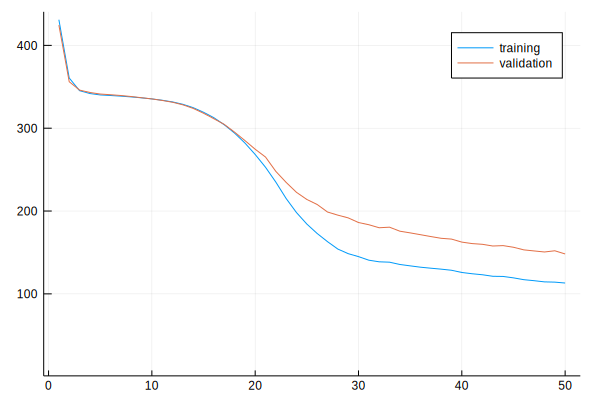

 21.666503 seconds (67.79 M allocations: 4.693 GiB, 9.67% gc time)


Progress:   1%|                                         |  ETA: 6:36:55

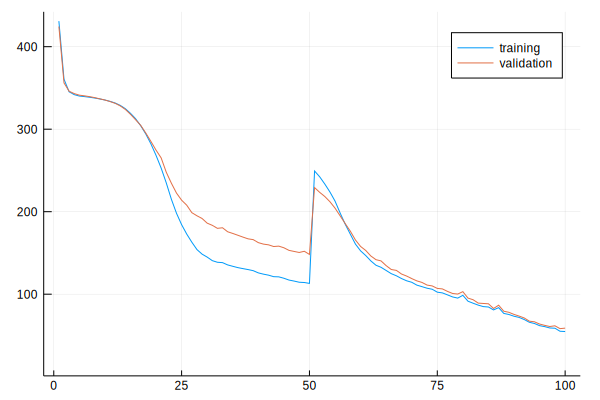

 37.793789 seconds (113.48 M allocations: 7.856 GiB, 10.41% gc time)


Progress:   2%|█                                        |  ETA: 7:42:13

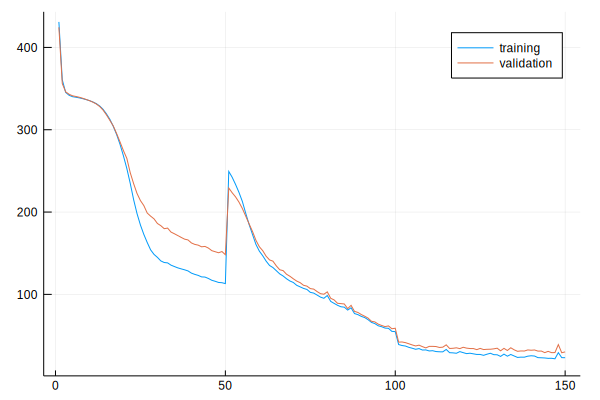

 58.532221 seconds (181.26 M allocations: 12.548 GiB, 9.17% gc time)


Progress:   3%|█                                        |  ETA: 6:54:17

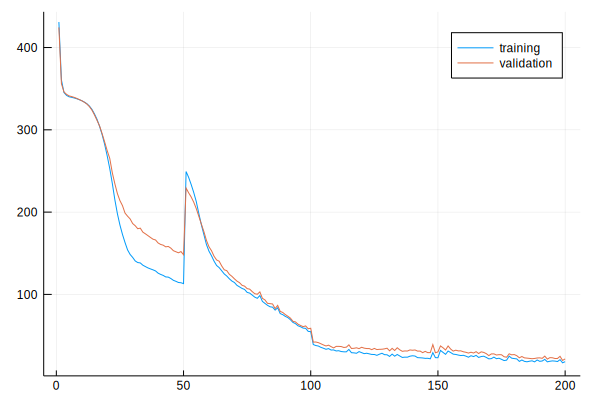

 81.934162 seconds (249.04 M allocations: 17.240 GiB, 10.68% gc time)


Progress:   4%|██                                       |  ETA: 7:14:56

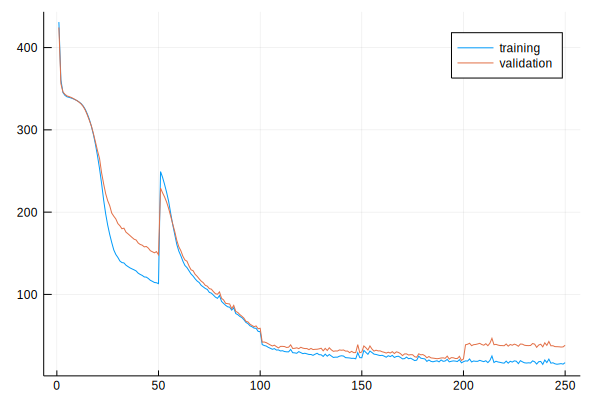

 92.240806 seconds (295.35 M allocations: 20.446 GiB, 8.18% gc time)


Progress:   5%|██                                       |  ETA: 6:43:34

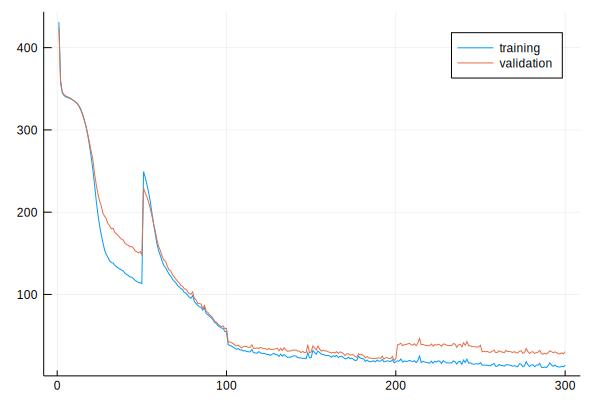

119.424995 seconds (363.13 M allocations: 25.138 GiB, 10.12% gc time)


Progress:   6%|██                                       |  ETA: 6:39:05

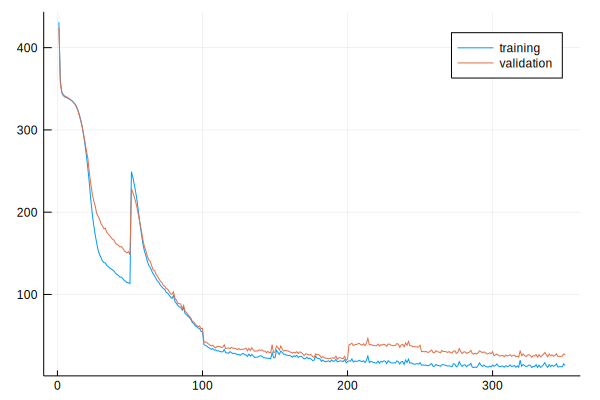

131.631127 seconds (408.92 M allocations: 28.308 GiB, 10.72% gc time)


Progress:   7%|███                                      |  ETA: 6:28:23

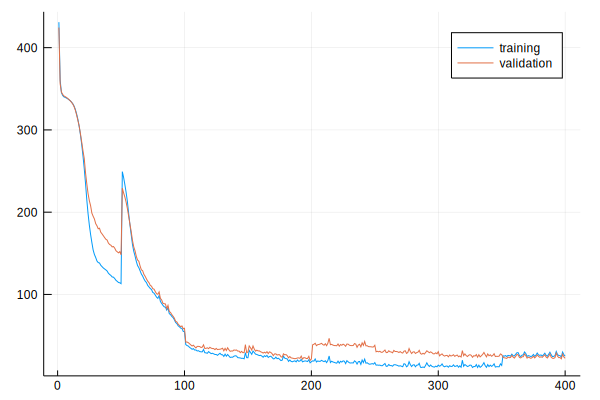

134.765909 seconds (432.03 M allocations: 29.908 GiB, 8.47% gc time)


Progress:   8%|███                                      |  ETA: 6:23:52

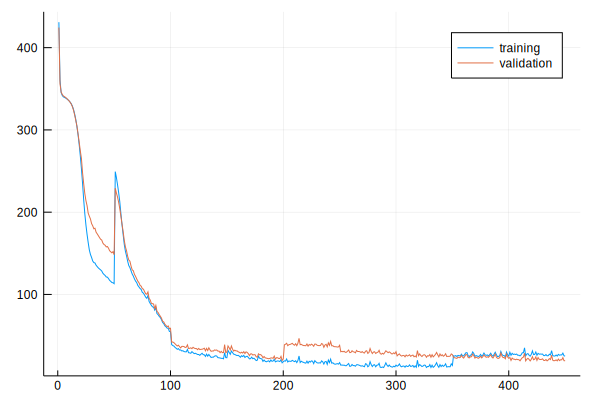

155.587072 seconds (477.48 M allocations: 33.054 GiB, 9.79% gc time)


Progress:   9%|████                                     |  ETA: 6:18:56

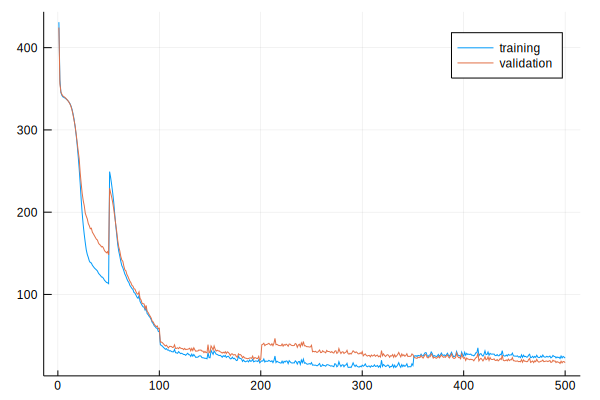

172.863257 seconds (545.25 M allocations: 37.745 GiB, 8.96% gc time)


Progress:  10%|████                                     |  ETA: 6:48:44

LoadError: [91mInterruptException:[39m

Unexpected end of input
 ...when parsing byte with value '0'
Stacktrace:
 [1] _error(::String, ::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:148
 [2] byteat(::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:58
 [3] chomp_space! at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:115 [inlined]
 [4] parse_value(::JSON.Parser.ParserContext{Dict{String,Any},Int64}, ::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:158
 [5] #parse#2(::Type{Dict{String,Any}}, ::Type{Int64}, ::Function, ::TCPSocket) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:406
 [6] macro expansion at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Lazy/src/macros.jl:241 [i

In [19]:
function mirror(s::S) where {S <: LearningMPC.Sample}
    S(-1 .* s.state,
      -1 .* s.input,
      s.x0,
      s.u0,
      s.warmstart_costs,
      s.mip)
end

datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 100
σv = 5.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    collect_into!(dataset.training_data, σv)
    collect_into!(dataset.training_data, 0.1 * σv)
    collect_into!(dataset.training_data, 0.01 * σv)
    
    filter!(dataset.training_data) do sample
        all(isfinite, sample.input)
    end

    
    new_samples = tuple.(dataset.training_data)
    if !isempty(new_samples)
        new_training, new_validation = splitobs(shuffleobs(new_samples); at=0.8)
        append!(all_training_data, new_training)
        append!(all_validation_data, new_validation)
        
        # The cart-pole system is symmetric, so for every sample with state x and input u,
        # we can sythesize an example with state -x and input -u with the same cost bounds
        append!(all_training_data, tuple.(mirror.(first.(new_training))))
        
        # The cart-pole system is symmetric, so for every sample with state x and input u,
        # we can sythesize an example with state -x and input -u with the same cost bounds
        append!(all_validation_data, tuple.(mirror.(first.(new_validation))))
    end

    @time for i in 1:50
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen(dataset_file, "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["losses"] = losses
    end
    
    jldopen(library_file, "w") do file
        file["training"] = all_training_data
        file["testing"] = all_validation_data
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (1, ylims(plt)[2]))
    display(plt)

end